# Simple graph experiment to investigate inner workings

This experiments seeks to provide a better understanding of how, and possibly if, the directed GraphSAGE algorithm works in its entirety.

Import NetworkX and stellar:

In [1]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.data.explorer import DirectedBreadthFirstNeighbours
from stellargraph.mapper import DirectedGraphSAGENodeGenerator
from stellargraph.layer import DirectedGraphSAGE

from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

Using TensorFlow backend.
/Users/doc019/.envs/sgdev/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/doc019/.envs/sgdev/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/doc019/.envs/sgdev/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/doc019/.envs/sgdev/lib/python3.6/site-pa

### Load a simple graph

Create the graph with directed edges

In [2]:
Gnx = nx.DiGraph()
Gnx.add_edges_from([(1,2),(2,3)])

Create the features for the nodes

In [3]:
feature_names = ["f0"]
column_names =  ["id"] + feature_names
node_data = pd.DataFrame([[1,1.0],[2,0.0],[3,2.0]], columns=column_names)
node_data = node_data.set_index("id")
print(node_data)

     f0
id     
1   1.0
2   0.0
3   2.0


In [4]:
node_features = node_data[feature_names]
print(node_features)

     f0
id     
1   1.0
2   0.0
3   2.0


## Create the StellarGraph

In [5]:
G = sg.StellarDiGraph(Gnx, node_features=node_features)

In [6]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 3, Edges: 2

 Node types:
  default: [3]
    Edge types: default-default->default

 Edge types:
    default-default->default: [2]



Let us use all nodes

In [7]:
nodes = list(G.nodes())
print(nodes)

[1, 2, 3]


Check on the features

In [8]:
features = G.get_feature_for_nodes(nodes)
print(features)

[[1.]
 [0.]
 [2.]]


Let us look at directed sampling

In [9]:
sampler = DirectedBreadthFirstNeighbours(G)

Examine 1-hop sampling:

In [10]:
res = sampler.run(nodes=nodes, in_size=[1], out_size=[1])
for node_sample in res:
    print(node_sample)

[[1], [None], [2]]
[[2], [1], [3]]
[[3], [2], [None]]


Examine 2-hop sampling:

In [11]:
res = sampler.run(nodes=nodes, in_size=[1, 1], out_size=[1, 1])
for node_sample in res:
    print(node_sample)

[[1], [None], [2], [None], [None], [1], [3]]
[[2], [1], [3], [None], [2], [2], [None]]
[[3], [2], [None], [1], [3], [None], [None]]


Now examine the node generator:

In [12]:
generator = DirectedGraphSAGENodeGenerator(G, batch_size=len(nodes), in_samples=[1], out_samples=[1])

In [13]:
train_data = node_data.index
train_gen = generator.flow(train_data, shuffle=False)
print(train_gen)

Let us delve into the inner workings:

In [14]:
features = train_gen.generator.sample_features(nodes, train_gen._sampling_schema)

In [15]:
print(features)

[array([[[1.]],

       [[0.]],

       [[2.]]]), array([[[0.]],

       [[1.]],

       [[0.]]]), array([[[0.]],

       [[2.]],

       [[0.]]])]


******************************************************************************

Let us see what happens when we ignore in-nodes:

In [16]:
batch_size = 3; in_samples = [0, 0]; out_samples = [1, 1]

A `DirectedGraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras

In [17]:
generator = DirectedGraphSAGENodeGenerator(G, batch_size, in_samples, out_samples)

Using the `generator.flow()` method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use all nodes.

In [18]:
train_data = node_data.index
train_gen = generator.flow(train_data, shuffle=False)
print(train_gen)

In [19]:
features = train_gen.generator.sample_features(nodes, train_gen._sampling_schema)
features

[array([[[1.]],
 
        [[0.]],
 
        [[2.]]]), array([], shape=(3, 0, 1), dtype=float64), array([[[0.]],
 
        [[2.]],
 
        [[0.]]]), array([], shape=(3, 0, 1), dtype=float64), array([], shape=(3, 0, 1), dtype=float64), array([], shape=(3, 0, 1), dtype=float64), array([[[2.]],
 
        [[0.]],
 
        [[0.]]])]

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 48-dimensional hidden node features at each layer, which corresponds to 16 weights for a node, 16 for the in-nodes (unused) and 16 for the out-nodes. This corresponds to the 32 dimensions used in example 1 (where we do not distinguish between in-nodes and out-nodes).
 * The `bias` and `dropout` are internal parameters of the model. 

In [20]:
graphsage_model = DirectedGraphSAGE(
    layer_sizes=[48, 48],
    generator=train_gen,
    bias=False,
    dropout=0.5,
)

Now we create a model to predict the 7 categories using Keras softmax layers.

In [21]:
x_inp, x_out = graphsage_model.build()
prediction = layers.Dense(units=1, activation="softmax")(x_out)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [22]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Save the model

In [25]:
model.save("test_save_model.h5")

Load the model using the StellarGraph custom layers:

In [28]:
from keras.models import load_model

model = load_model("test_save_model.h5", custom_objects=sg.custom_keras_layers)

We can visualize the model:

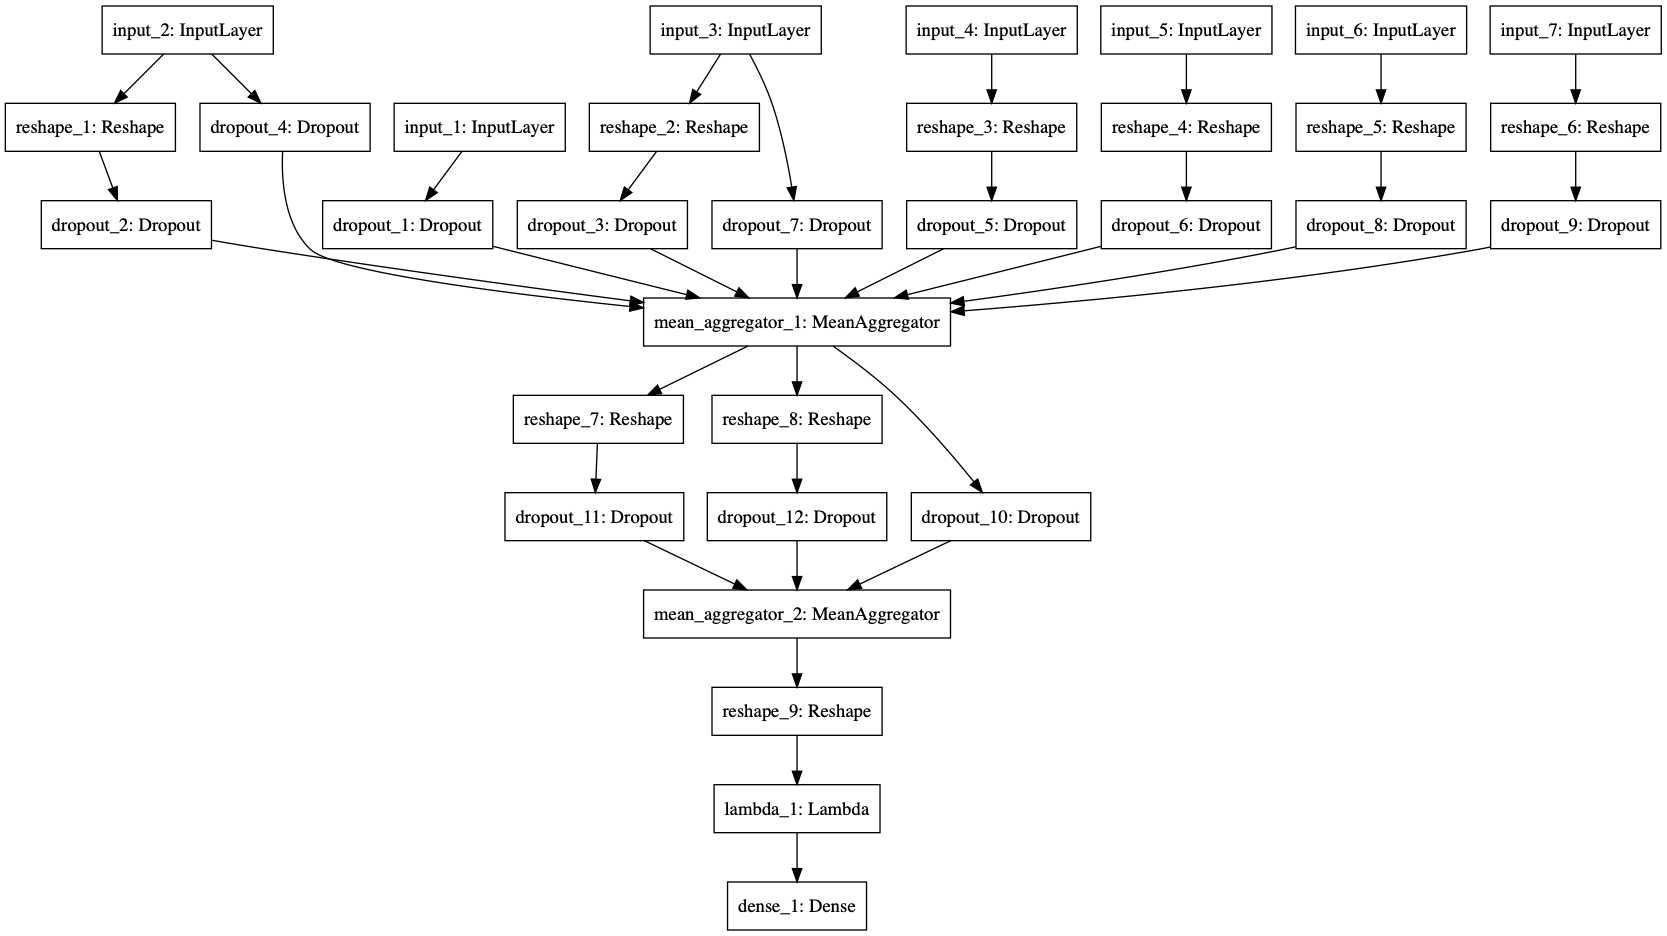

In [23]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
Image(model_to_dot(model).create_png())

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [ ]:
test_gen = generator.flow(test_data.index, test_targets)

In [ ]:
history = model.fit_generator(
    train_gen,
    epochs=20,
    validation_data=test_gen,
    verbose=2,
    shuffle=False
)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()

In [ ]:
plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [ ]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

### Making predictions with the model

Now let's get the predictions themselves for all nodes using another node iterator:

In [ ]:
all_nodes = node_data.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_mapper)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

In [ ]:
node_predictions = target_encoding.inverse_transform(all_predictions)

Let's have a look at a few:

In [ ]:
results = pd.DataFrame(node_predictions, index=all_nodes).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data['subject']})
df.head(10)

Add the predictions to the graph, and save as graphml, e.g. for visualisation in [Gephi](https://gephi.org)

In [ ]:
for nid, pred, true in zip(df.index, df["Predicted"], df["True"]):
    Gnx.node[nid]["subject"] = true
    Gnx.node[nid]["PREDICTED_subject"] = pred.split("=")[-1]

Also add isTrain and isCorrect node attributes:

In [ ]:
for nid in train_data.index:
    Gnx.node[nid]["isTrain"] = True
    
for nid in test_data.index:
    Gnx.node[nid]["isTrain"] = False

In [ ]:
for nid in Gnx.nodes():
    Gnx.node[nid]["isCorrect"] = Gnx.node[nid]["subject"] == Gnx.node[nid]["PREDICTED_subject"]

## Node embeddings
Evaluate node embeddings as activations of the output of graphsage layer stack, and visualise them, coloring nodes by their subject label.

The GraphSAGE embeddings are the output of the GraphSAGE layers, namely the `x_out` variable. Let's create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [ ]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [ ]:
emb = embedding_model.predict_generator(all_mapper)
emb.shape

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [ ]:
X = emb
y = np.argmax(target_encoding.transform(node_data[["subject"]].to_dict('records')), axis=1)

In [ ]:
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_data.index)
    emb_transformed['label'] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_data.index)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] = y

In [ ]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GraphSAGE embeddings for cora dataset'.format(transform.__name__))
plt.show()